In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model

import random
import sys
from scipy import stats

%load_ext autoreload
%autoreload 2
from regression_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Import Data

In [4]:
pod_number = 'F4'

In [5]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/F4_raw_features.csv', parse_dates = [0], index_col = 0)

##Declare whether to process raw or filtered data.

In [6]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [7]:
df_tr, df_hold, days_tr = add_day_sep_tr_and_holdout(df_all, ref_column)

####Call the scaling function and create a dataframe with scaled data.

In [8]:
df_scaled, features = scale_features_and_create_day_column(df_tr, ref_column)

####Create a custom cross-validation function that holds out each day.

In [34]:
lol = create_custom_cv(df_scaled)

#Linear Regression with Base Features

In [10]:
base_features = [pod_ozone,'Temp','Rh']

In [11]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T = cross_validation_by_day(lin_regr, base_features, df_scaled, days_tr, ref_column)

Cross-Validation MSE:  48  Training MSE:  34


####Plot the learning curve for a linear regression with the base features.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

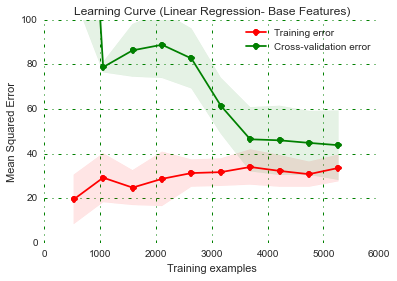

In [12]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,100), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 'mean_squared_error')

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

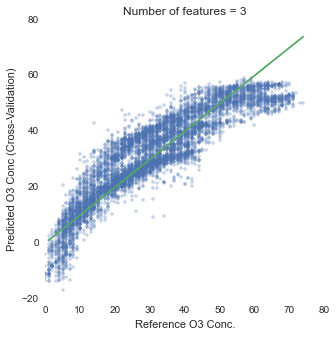

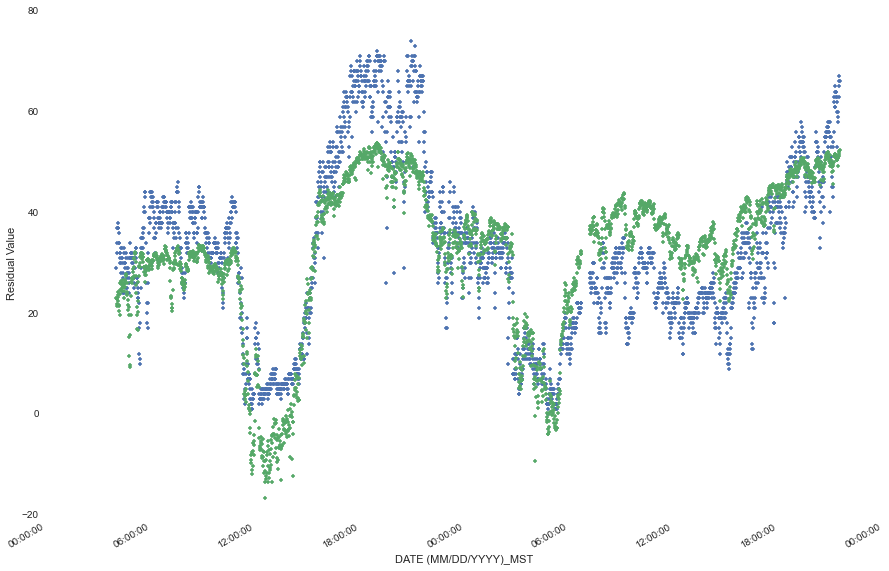

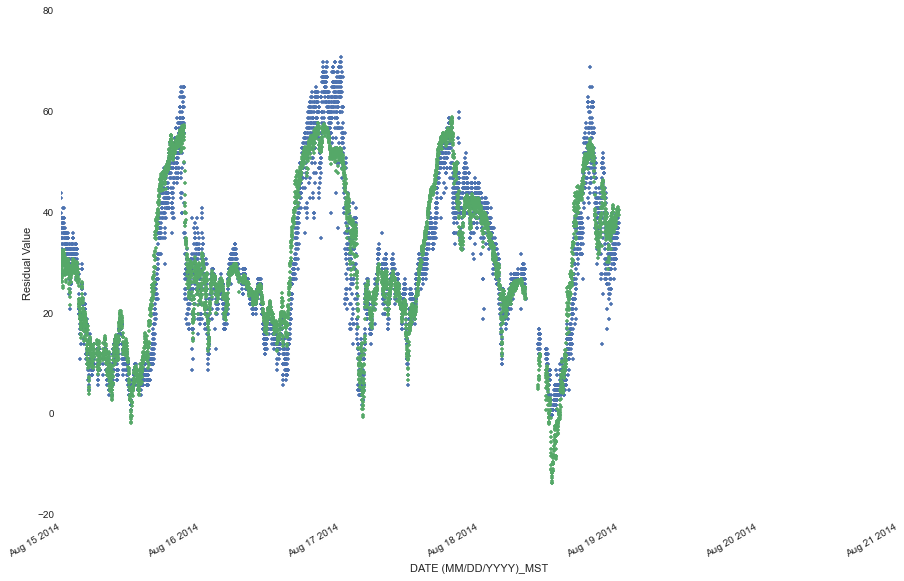

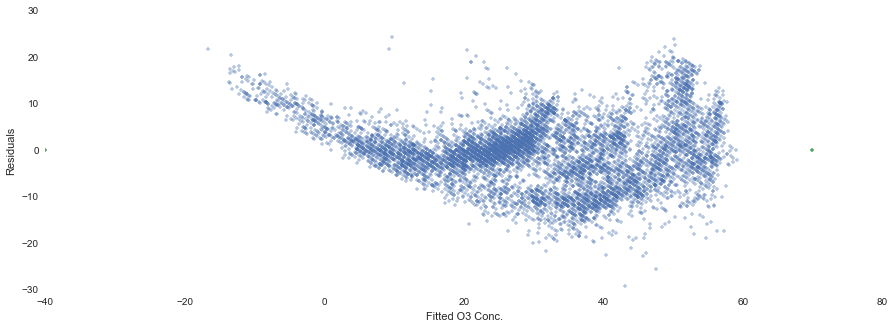

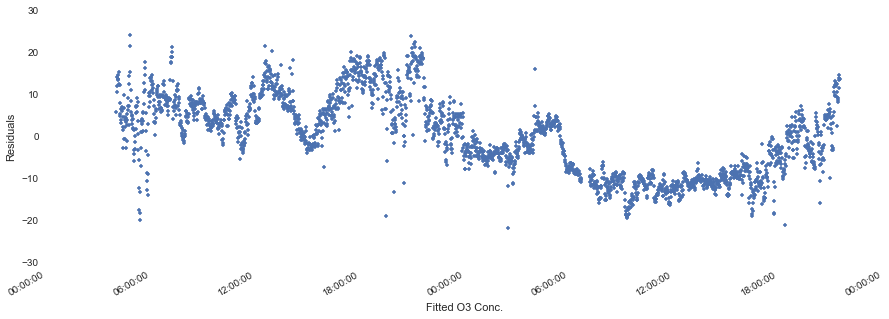

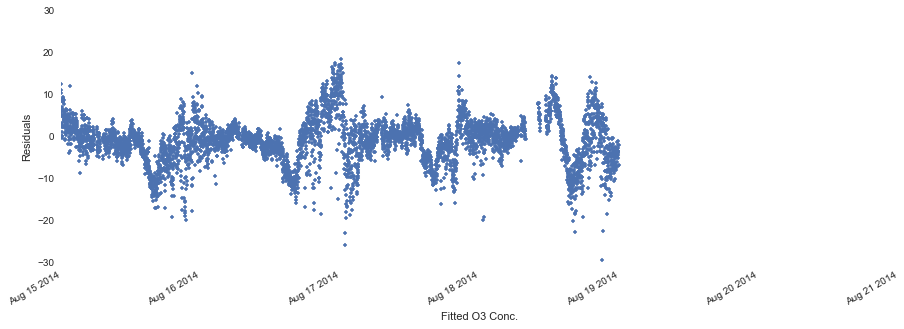

In [13]:
num_good_feat = len(base_features)
df_lin_regr_best_feat = find_fitted_cv_values_for_best_features(df_tr, base_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

###Linear Regression with All Features.

In [12]:
all_features = list(df_tr.ix[:,1:len(df_all.columns)-1])
#find the MSE
MSE_CV, MSE_T = cross_validation_by_day(lin_regr, all_features, df_scaled, days_tr, ref_column)

Cross-Validation MSE:  76  Training MSE:  6


####Plot a learning curve with all features.

In [17]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- All Features)", df_tr[all_features].values, df_tr[ref_column].values, (0,100), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 'mean_squared_error')

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

OverflowError: Allocated too many blocks

The uncertainty in the cross-validation score is enormous, and it's very far away, from the training score, which indicates that we now have high variance, and need to reduce the number of features.

###Plot the residuals and comparison curves.

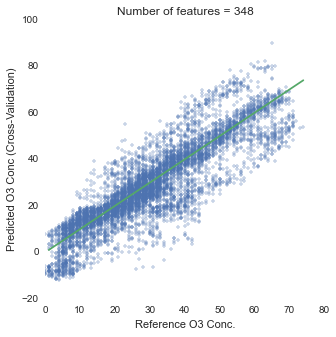

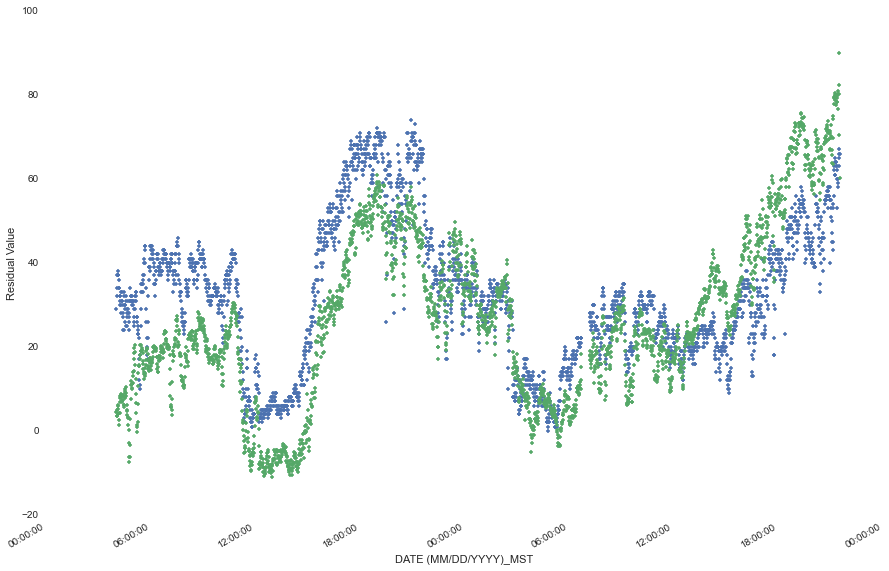

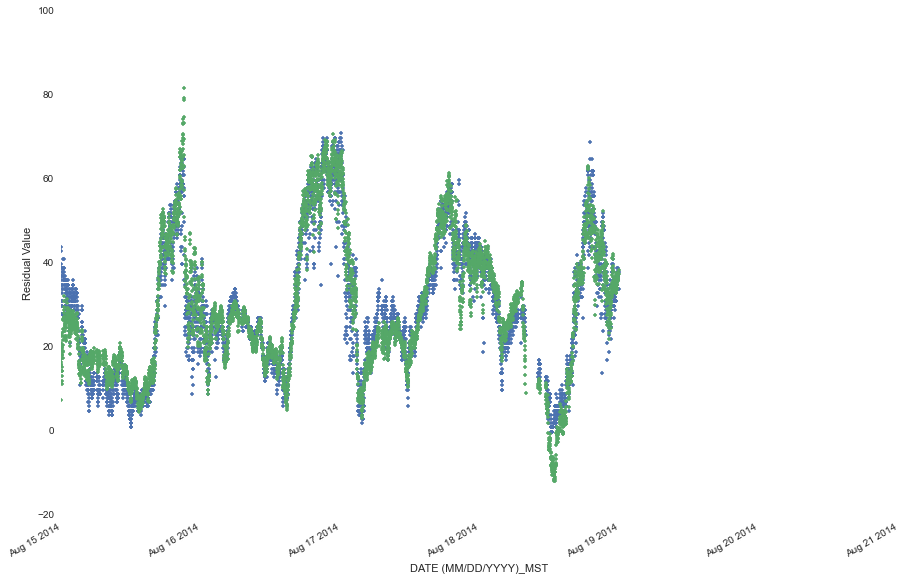

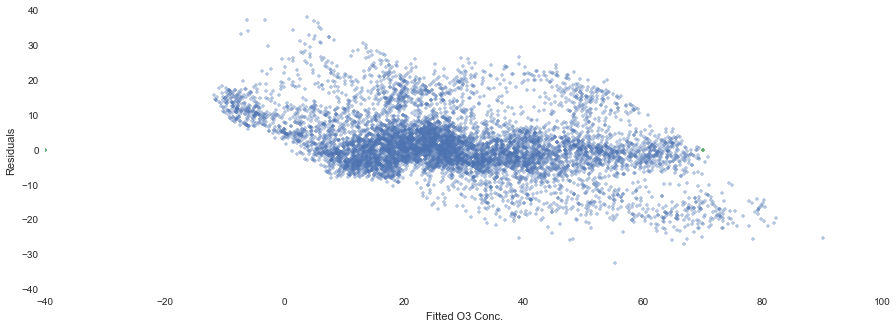

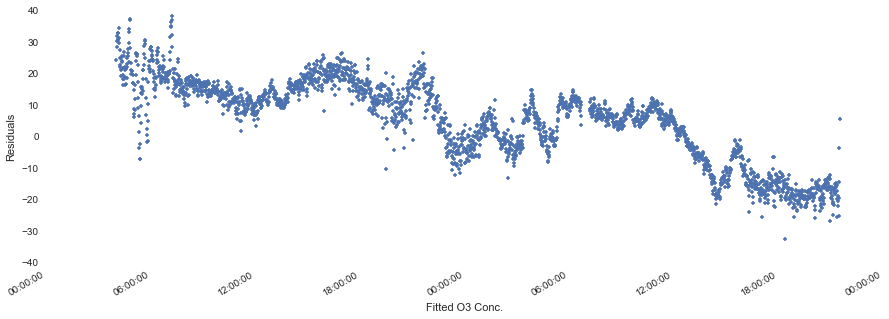

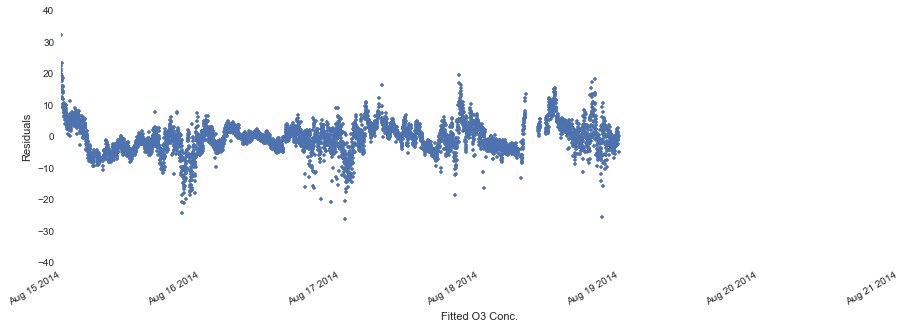

In [13]:
num_good_feat = len(all_features)
df_lin_regr_best_feat = find_fitted_cv_values_for_best_features(df_tr, all_features, num_good_feat, linear_model.LinearRegression(),days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [14]:
error_func = 'custom_mse' #'custom_mse', 'custom_mae' or 'mean_squared_error'

In [15]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime',leave_out_pod, ref_column,'days from start', 'day']
features = [f for f in features if f not in leave_out]
fs_features, score, MSE = forward_selection_lodo(lin_regr, features, df_tr[[ref_column] + features + ['days from start']].dropna(), error_func, ref_column, lol)

Next best Feature:  ln_O3_int_lead_35 , Score:  350.0 ,
Next best Feature:  temp_cu , Score:  88.7 ,
Next best Feature:  ln_O3_slope_lead_95 , Score:  47.7 ,
Next best Feature:  Temp_slope_lag_110 , Score:  37.3 ,
Next best Feature:  ln_O3_slope_lead_50 , Score:  33.0 ,
Next best Feature:  ln_rh_slope_lead_80 , Score:  30.0 ,
Next best Feature:  temp_rh_slope_lead_110 , Score:  26.3 ,
Next best Feature:  Temp_slope_lead_50 , Score:  25.0 ,
Next best Feature:  e2v03_slope_lead_95 , Score:  23.7 ,
Next best Feature:  o3_temp_int_lag_35 , Score:  22.7 ,
Next best Feature:  e2v03_slope_lag_5 , Score:  22.0 ,
Next best Feature:  ln_temp_slope_lag_80 , Score:  21.7 ,
Next best Feature:  ln_o3_temp_int_lead_95 , Score:  21.3 ,
Next best Feature:  ln_O3_int_lead_20 , Score:  21.0 ,
Next best Feature:  ln_03_mult_ln_temp , Score:  20.3 ,
Next best Feature:  Rh_slope_lead_80 , Score:  18.7 ,
Next best Feature:  e2v03_slope_lead_110 , Score:  18.3 ,
Next best Feature:  e2v03_int_slide_2_to_12_lea

In [16]:
def plot_error_vs_features(score, MSE):
    x = range(0, len(score))
    plt.plot(x, score, 'bo-')
    plt.plot(x, MSE, 'ro-')
    plt.ylim((0,100))
    plt.xlabel('Number of Features')
    plt.ylabel('Error')
    plt.grid(b=True, which='major', color='g', linestyle='-.')
    print 'Custom Score: ', score
    print 'MSE: ', MSE

Custom Score:  ['350.0', '88.7', '47.7', '37.3', '33.0', '30.0', '26.3', '25.0', '23.7', '22.7', '22.0', '21.7', '21.3', '21.0', '20.3', '18.7', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.3', '18.0', '18.0', '18.0', '17.7', '16.3', '15.7', '15.7', '15.7', '15.7', '15.7', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.3', '15.0', '15.0', '15.0', '15.0', '15.0', '14.7', '14.7']
MSE:  ['537.1', '132.1', '91.1', '64.2', '76.2', '69.8', '70.2', '63.3', '68.2', '66.5', '62.4', '62.6', '63.6', '65.0', '57.1', '54.9', '55.9', '55.9', '55.9', '55.9', '55.9', '55.9', '55.9', '55.9', '54.6', '57.8', '58.5', '58.2', '67.2', '63.3', '57.6', '57.8', '58.3', '56.8', '57.8', '59.9', '57.0', '59.1', '59.8', '59.5', '59.8', '58.7', '59.1', '58.2', '58.4', '58.3', '58.2', '57.9', '55.5', '57.0', '55.3', '57.4', '51.6', '57.1', '53.5', '53.7', '54.5', '55.1', '61.0', '60.6']


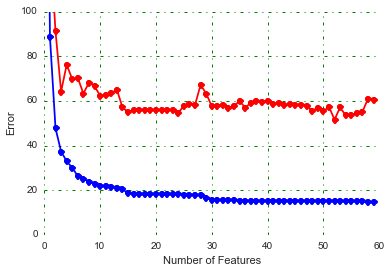

In [17]:
plot_error_vs_features(score, MSE)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


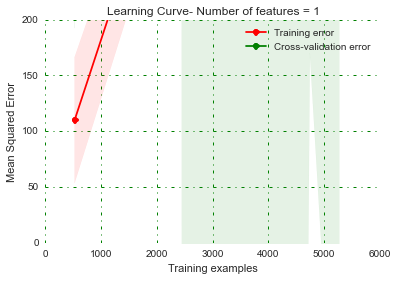

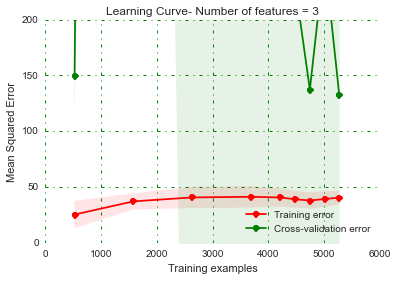

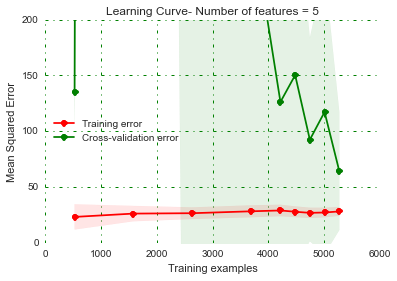

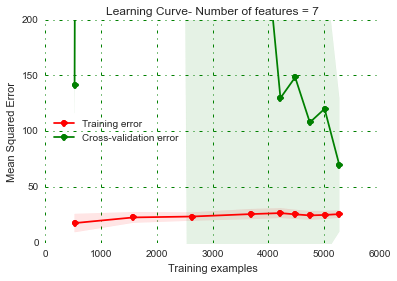

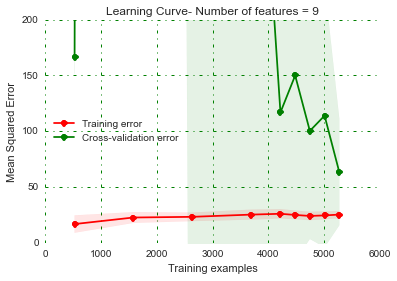

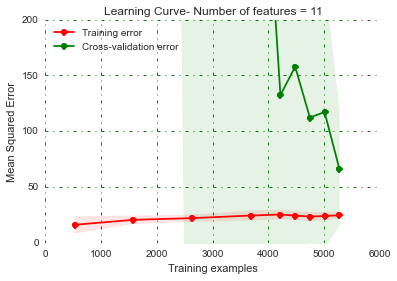

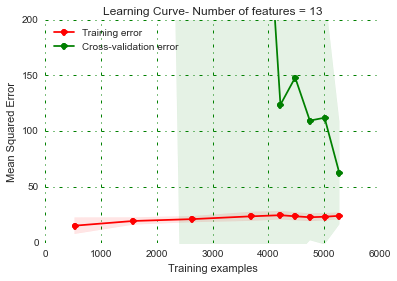

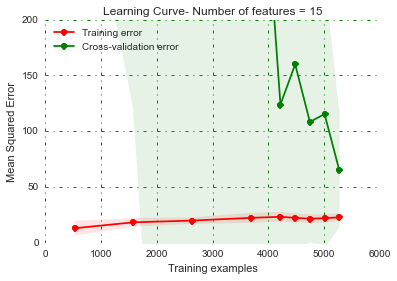

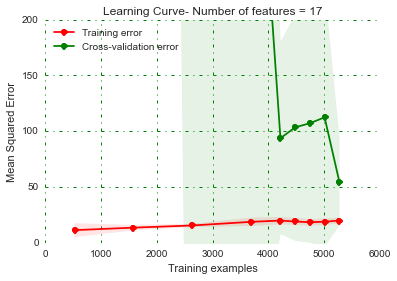

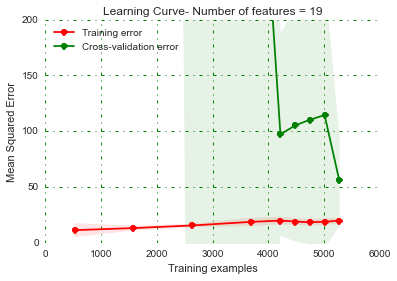

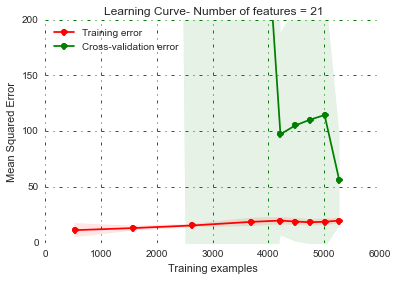

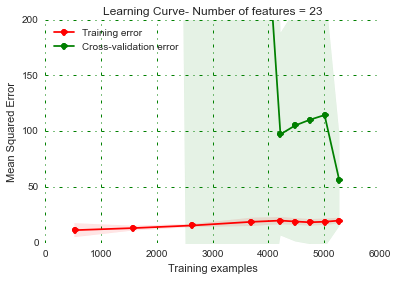

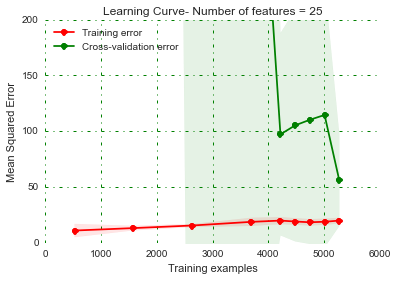

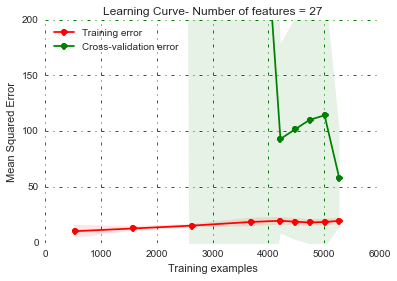

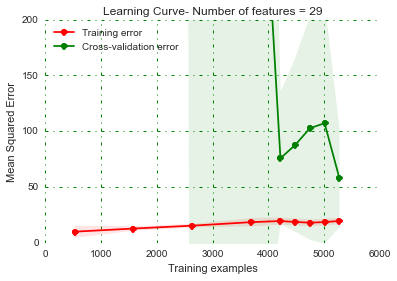

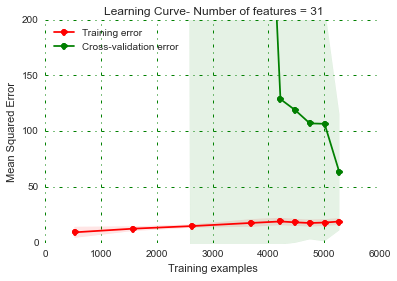

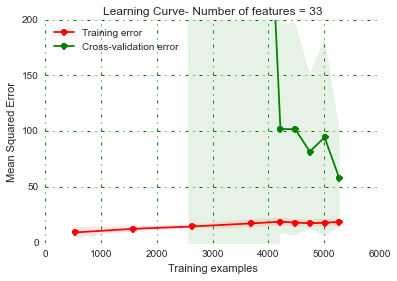

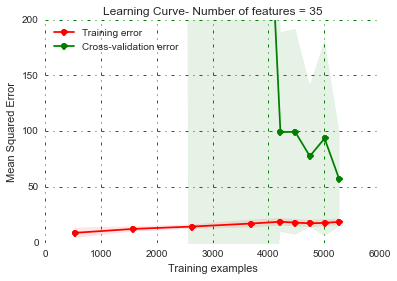

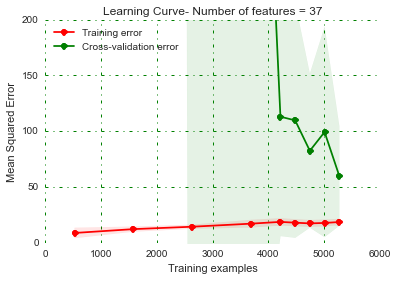

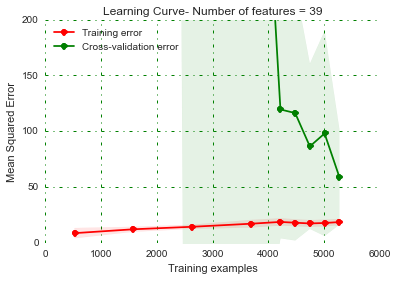

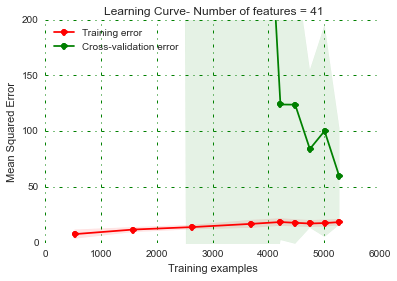

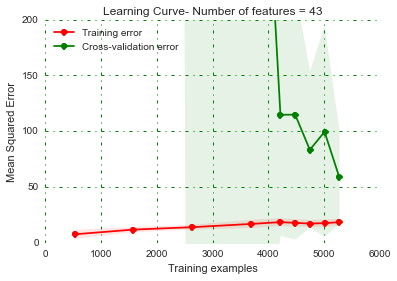

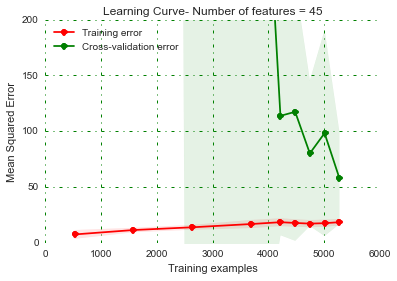

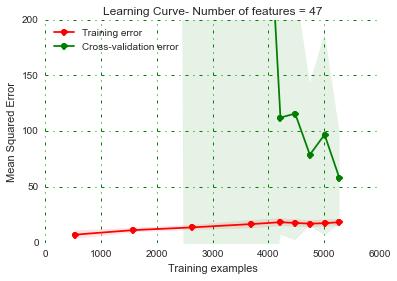

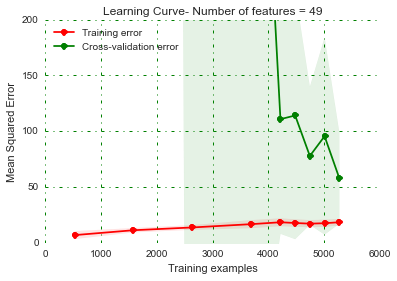

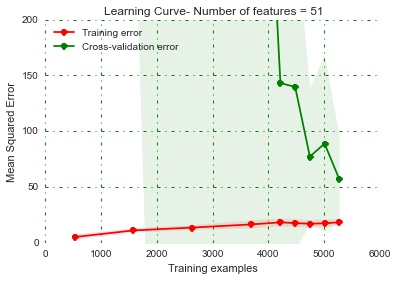

In [18]:
i = 1
while i <= 51:
    #title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,200), lol, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]), 'mean_squared_error')
    i += 2

#Check Residuals

###Plot cross-validation fitted data versus reference data, and choose number of features.

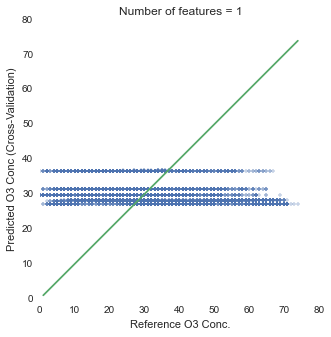

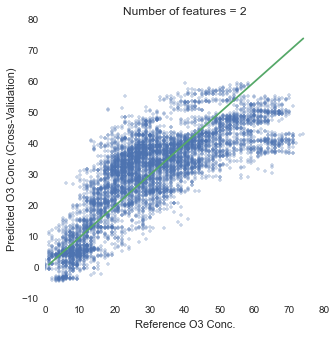

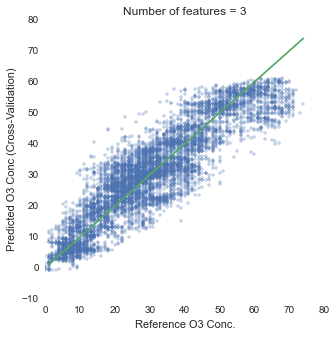

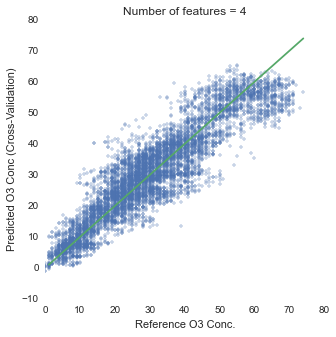

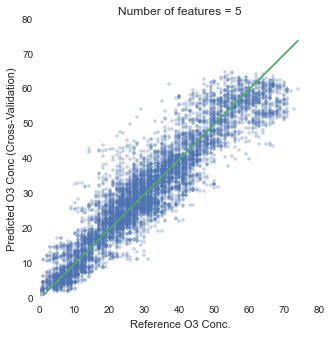

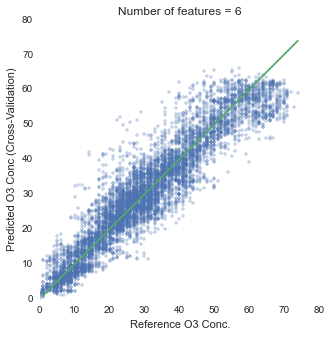

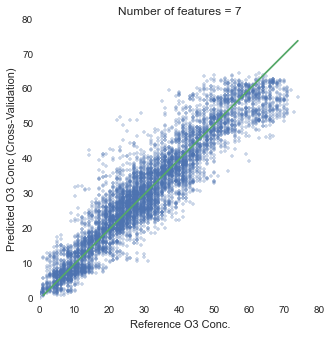

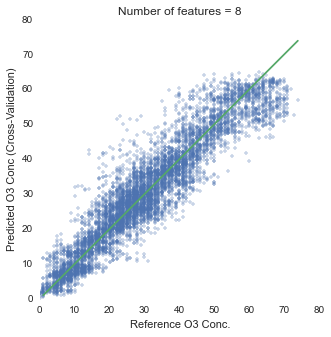

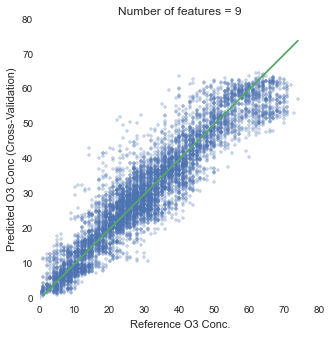

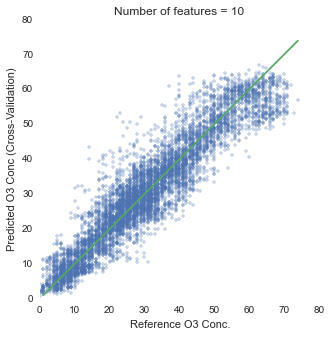

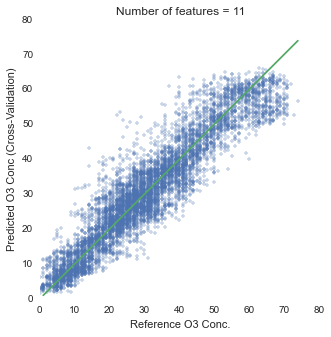

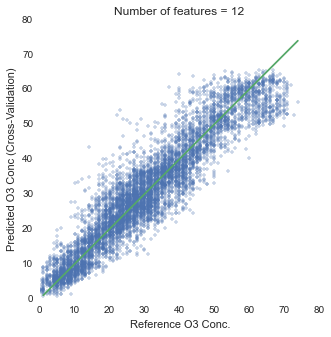

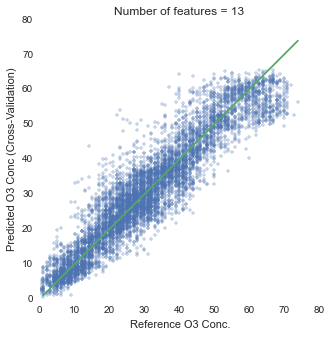

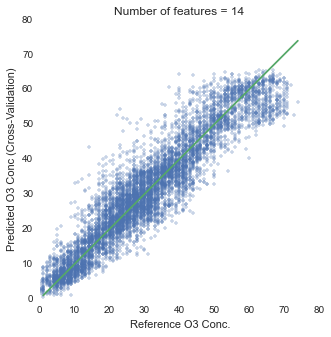

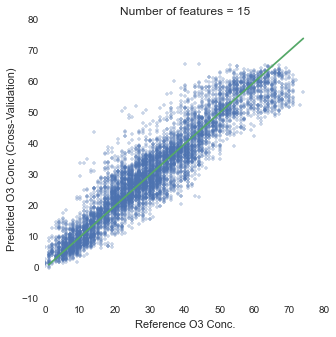

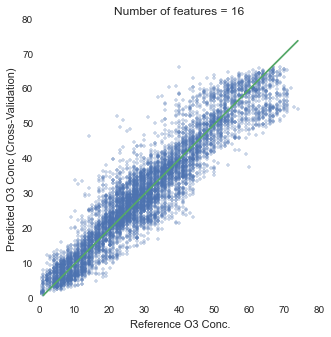

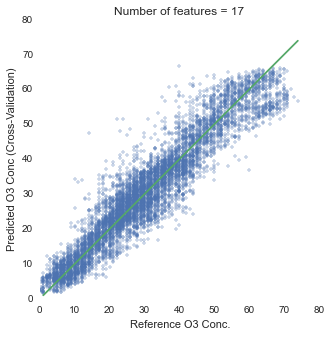

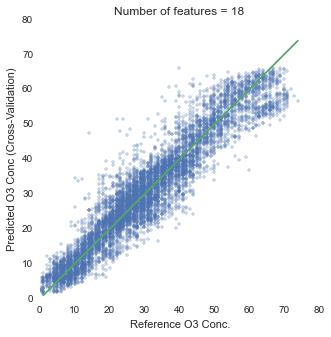

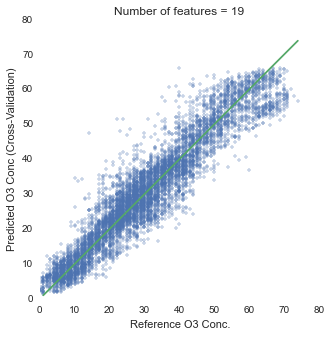

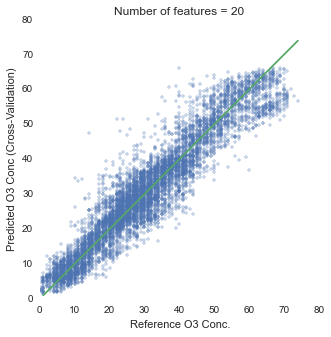

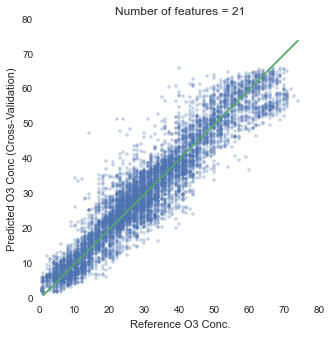

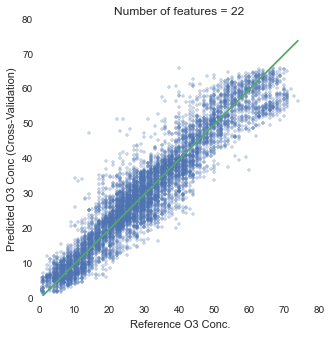

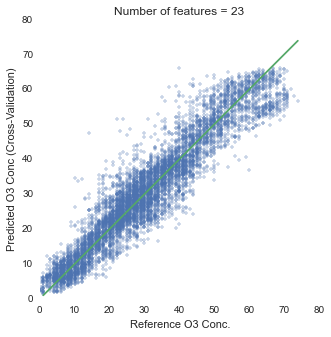

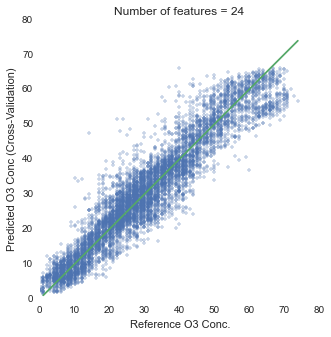

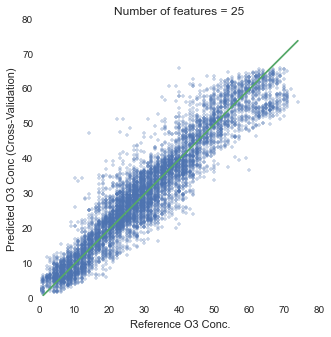

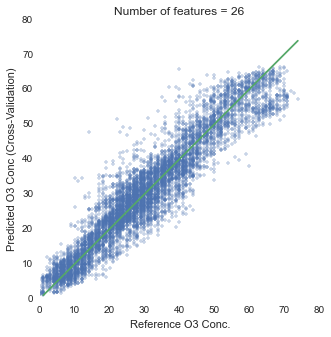

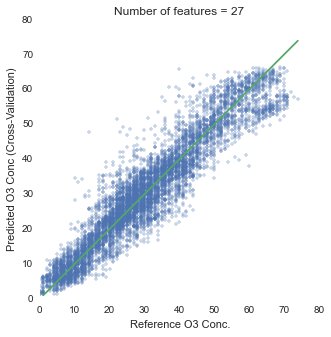

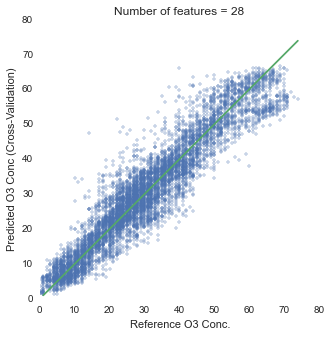

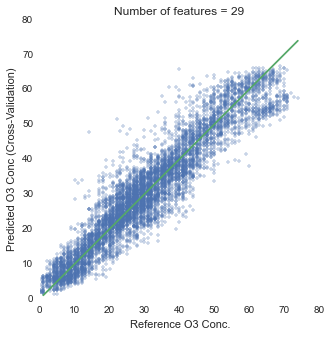

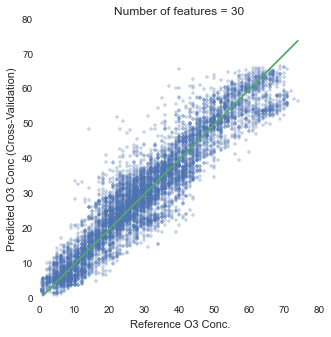

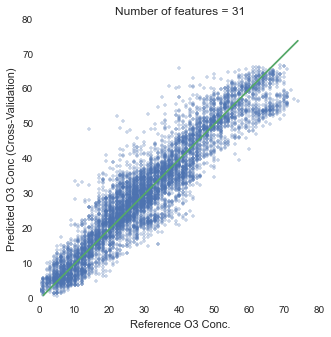

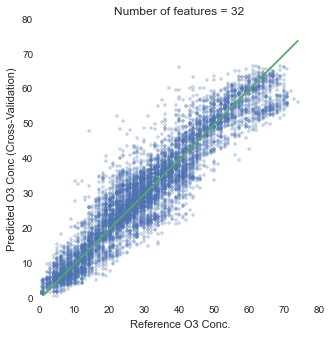

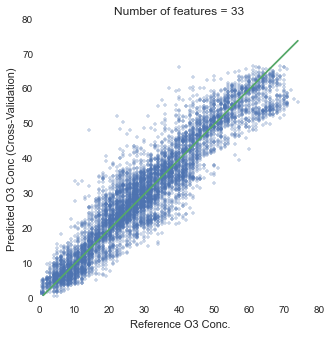

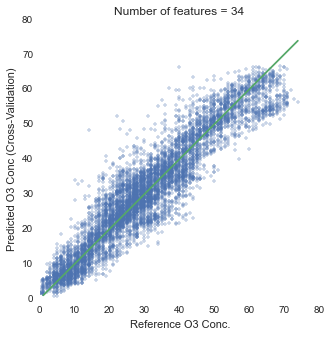

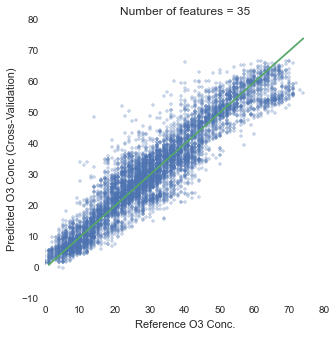

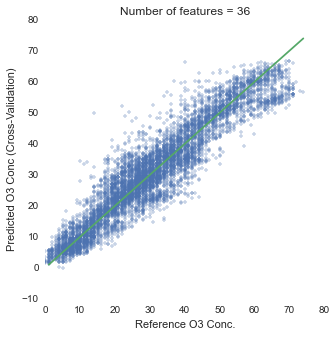

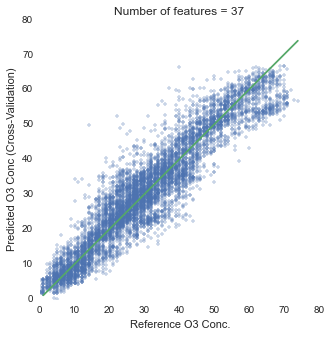

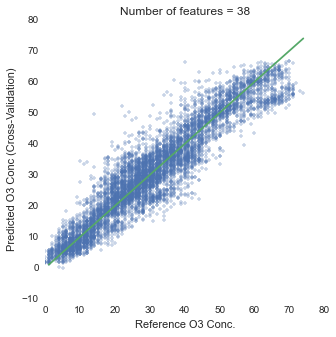

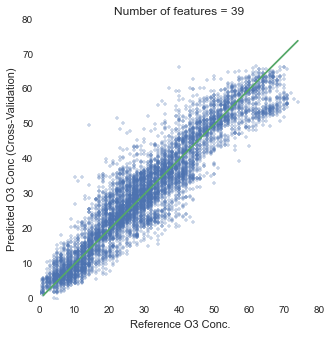

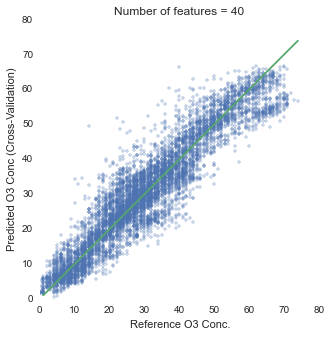

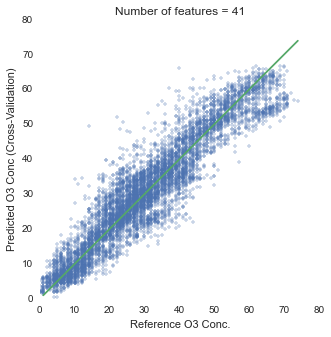

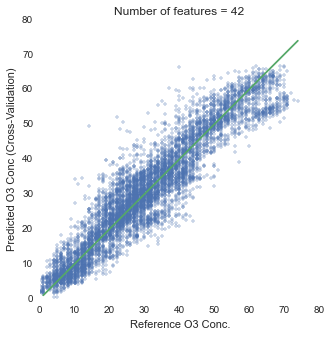

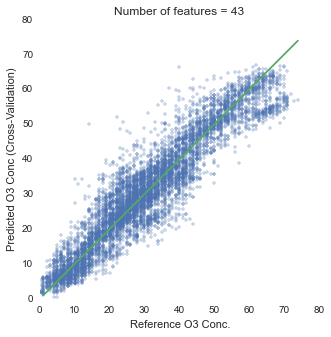

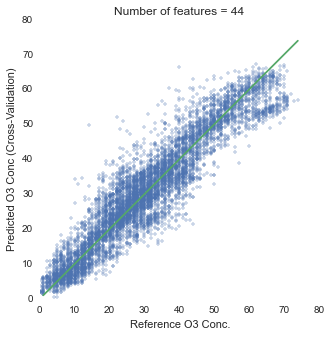

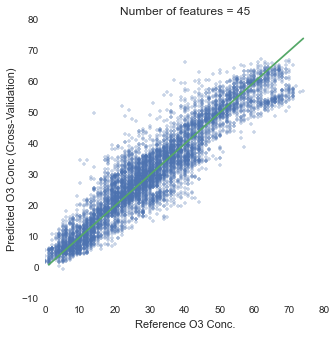

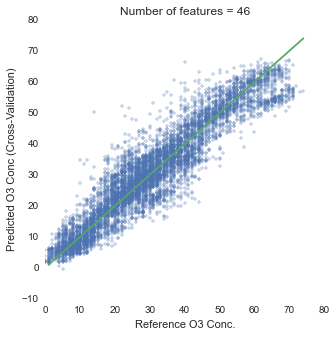

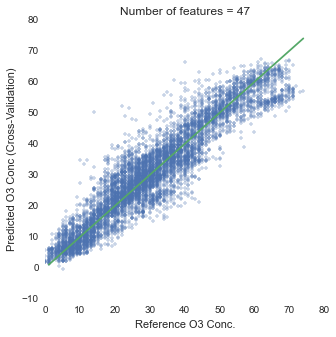

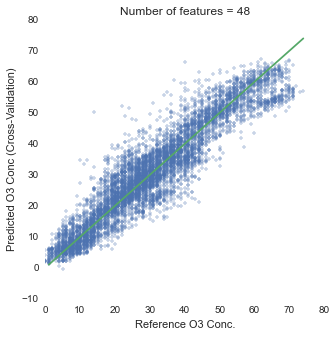

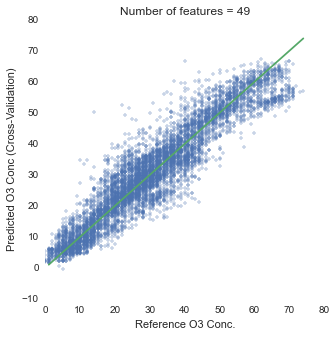

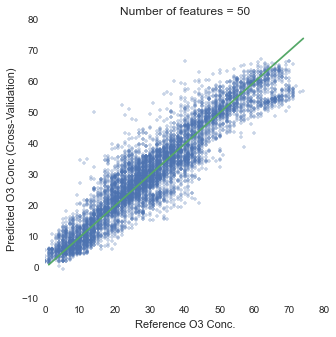

In [16]:
for i in range(1,len(fs_features)):
    num_good_feat = i
    df = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
    fitted_vs_ref_plot(df, i, ref_column) 

###Enter the chosen number of features, and plot the cv data and residuals below.

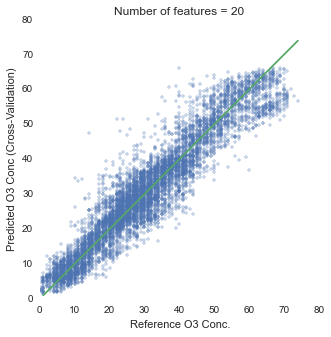

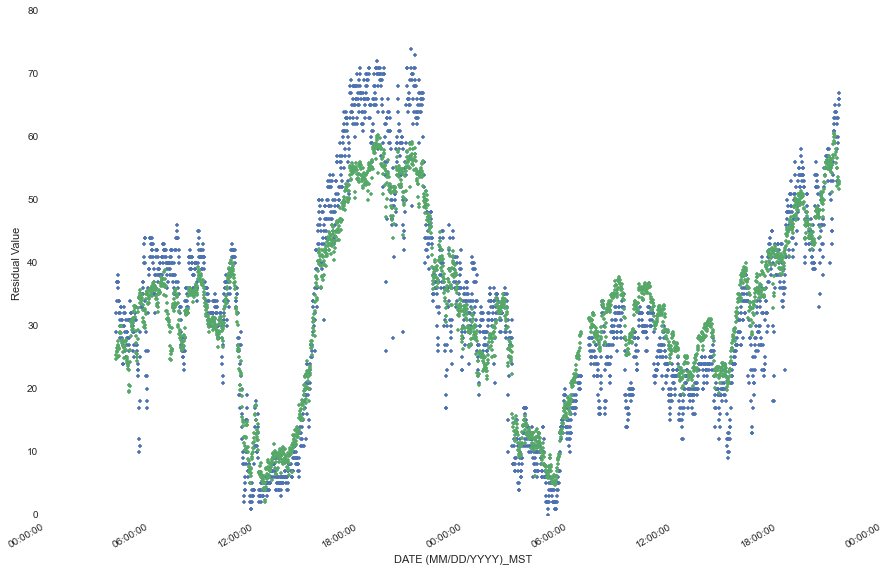

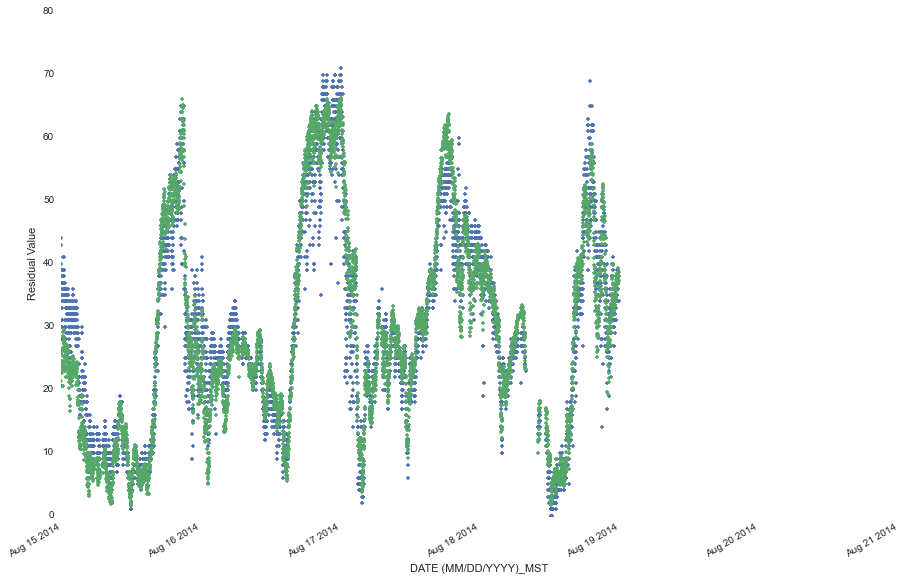

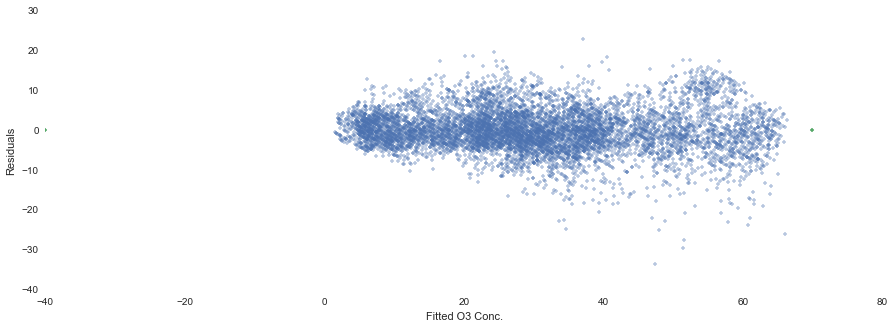

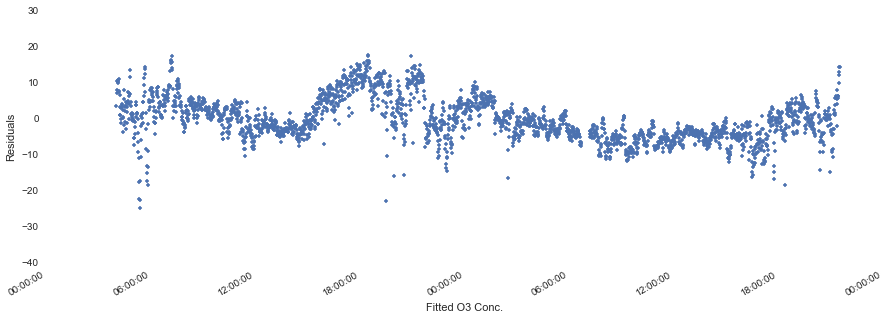

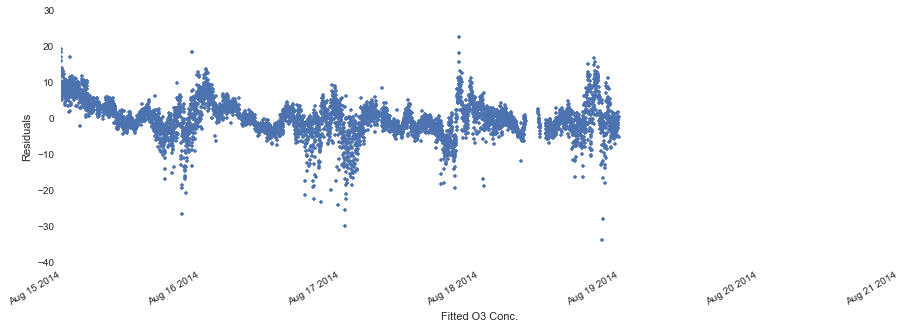

In [19]:
num_good_feat = 20
df_lin_regr_best_feat = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)

fitted_vs_ref_plot(df_lin_regr_best_feat, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Ridge Regression

In [38]:
#fs_features = ['e2v03','Temp','Rh']
#fs_features = ['days from start', 'ln_O3_int_lead_35', 'temp_cu', 'ln_O3_slope_lead_95', 'Temp_slope_lag_110', 'ln_O3_slope_lead_50', 'ln_rh_slope_lead_80', 'temp_rh_slope_lead_110', 'Temp_slope_lead_50', 'e2v03_slope_lead_95', 'o3_temp_int_lag_35', 'e2v03_slope_lag_5', 'ln_temp_slope_lag_80', 'ln_o3_temp_int_lead_95', 'ln_O3_int_lead_20', 'ln_03_mult_ln_temp', 'Rh_slope_lead_80', 'e2v03_slope_lead_110', 'e2v03_int_slide_2_to_12_lead', 'ln_O3_int_slide_2_to_12_lead', 'Temp_int_slide_2_to_12_lead', 'ln_temp_int_slide_2_to_12_lead', 'Rh_int_slide_2_to_12_lead', 'ln_rh_int_slide_2_to_12_lead', 'ln_O3_slope_lag_5', 'ln_temp_slope_lag_95', 'o3_rh_slope_lead_95', 'ln_temp_slope_lag_65', 'Rh_slope_lag_110', 'ln_rh_slope_lag_110', 'temp_rh_slope_lag_110', 'ln_o3_temp_int_lag_95', 'ln_temp_slope_lag_5', 'Rh_slope_lag_5', 'ln_O3_slope_lag_50', 'Temp_slope_lag_50', 'Rh_slope_lag_50', 'ln_O3_int_lag_5', 'ln_O3_int_lag_20', 'e2v03_slope_lag_35', 'ln_O3_slope_lag_35', 'ln_temp_slope_lag_20', 'Rh_slope_lag_20', 'Rh_slope_lag_35', 'e2v03_slope_lag_50', 'Rh_slope_lag_65', 'Rh_slope_lag_80', 'Rh_slope_lag_95', 'e2v03_slope_lead_35', 'ln_o3_temp_slope_lag_35', 'ln_O3_int_lag_35', 'temp_rh_slope_lag_65', 'ln_O3_int_lag_50', 'ln_rh_slope_lag_80', 'e2v03_slope_lead_20', 'ln_rh_slope_lag_65', 'ln_O3_slope_lead_35', 'o3_temp_slope_lag_35', 'temp_rh_slope_lag_95', 'temp_rh_slope_lag_35', 'ln_rh_slope_lag_95']
num_good_feat = len(fs_features)

In [39]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

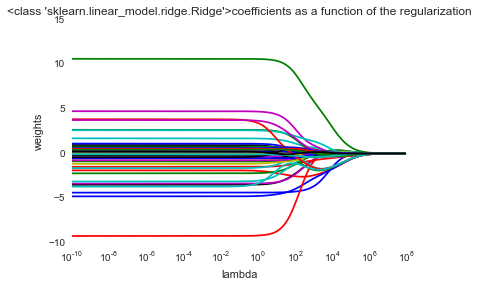

Best Lambda:  1e-10
Custom Error:  15
CV Mean Squared Error:  60


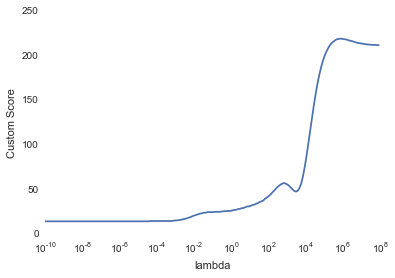

In [56]:
best_lambda_ridge, custom_sc_ridge, MSE_ridge = find_best_lambda(Ridge, fs_features[:num_good_feat], df_fits, ref_column, 'custom_mse', lol, X, y)

####Use the best lambda value found above to find holdout values.

In [57]:
df_ridge_fit = find_residuals_and_fitted_cv_values(Ridge, df_tr, fs_features[:num_good_feat], days_tr, ref_column, best_lambda_ridge)

Coefficients:  [ -2.58031667e-01  -2.48887764e-01   5.76849885e-04   4.89754910e+02
  -9.55232102e+01  -1.67040494e+02  -1.00726287e+03   6.87662423e+01
  -3.21366283e+01  -1.05351090e+01  -2.50392423e-06  -4.11471348e-01
   4.67091217e+02   5.44714205e-04  -6.03701061e-01  -8.15422945e+00
   2.99049522e+01   4.44269356e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.89716263e+01   4.66145372e+02   1.24037790e+01  -9.74540135e+02
   4.09000171e+00  -8.75082042e+01  -1.11309245e+02   2.96554763e-04
   8.90591475e+01   7.59390771e-02  -1.14677643e+02   3.38670918e+01
  -4.05136806e-01   3.09347310e-02   1.20081256e-02   3.11115925e-01
  -1.42159856e+01   1.32276571e+02   1.46084954e+00   6.24185457e+00
   3.28859779e+00  -2.55704041e+01  -7.47518855e+00  -3.50669906e+00
  -1.74936368e+00  -1.52366010e+04   3.55288220e-01   5.27113567e+01
  -2.03255502e-01   4.40610235e+02   1.25665374e+00   6.72697383e+02
   8.94788417e+01  

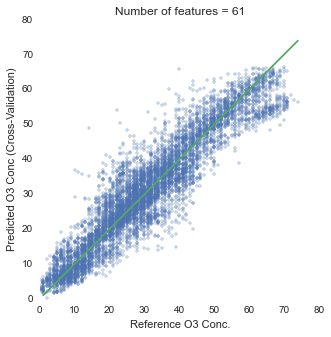

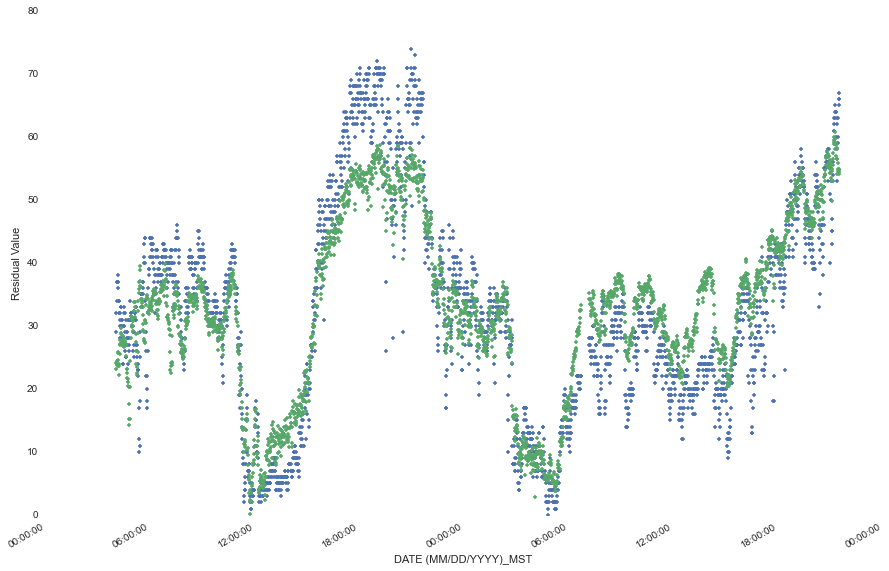

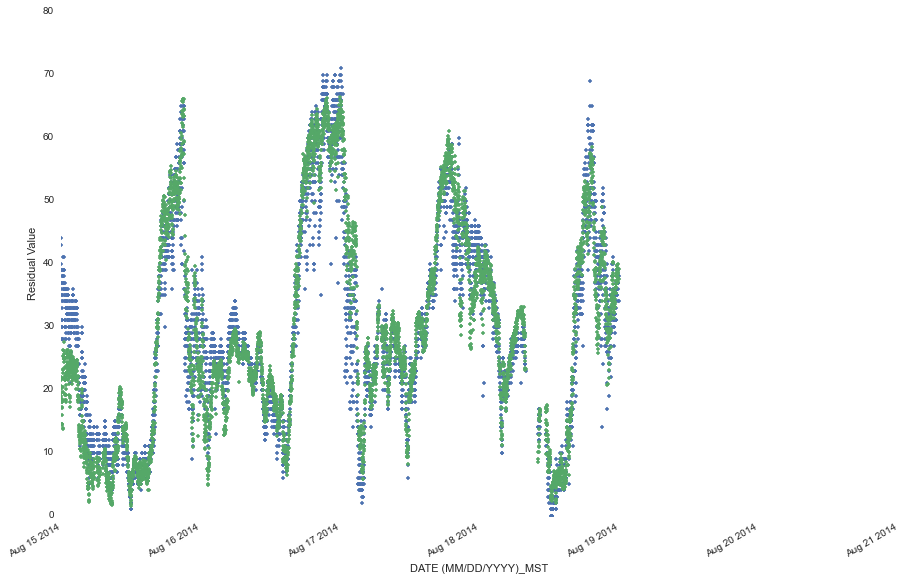

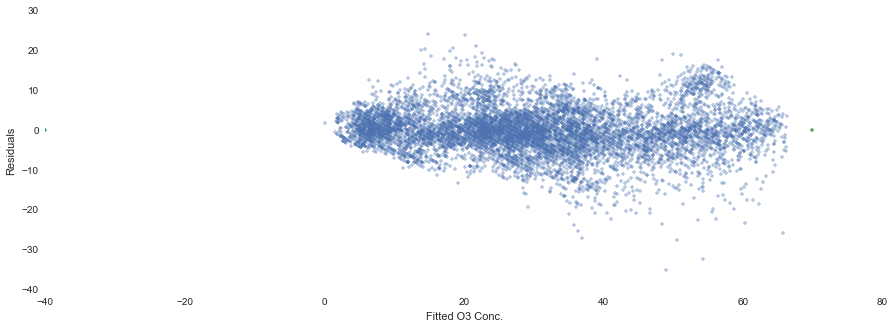

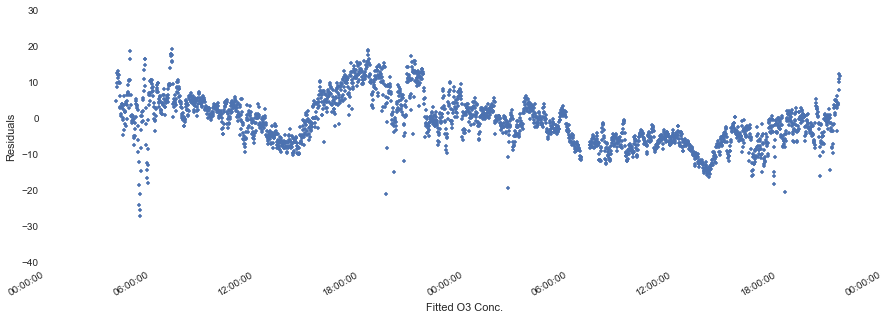

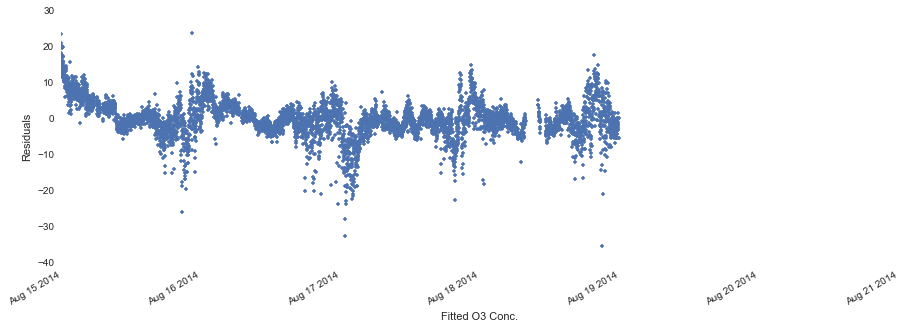

In [49]:
fitted_vs_ref_plot(df_ridge_fit, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_ridge_fit, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

NameError: name 'ridge' is not defined

#Lasso

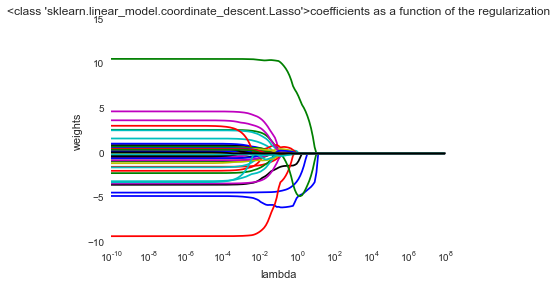

Best Lambda:  1e-10
Custom Error:  15
CV Mean Squared Error:  60


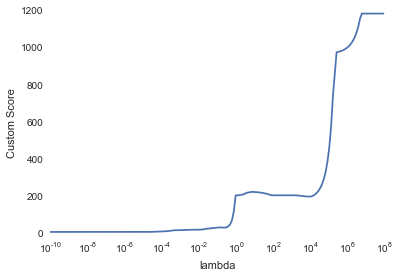

In [58]:
best_lambda_lasso, custom_sc_lasso, MSE_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat], df_fits, ref_column, 'custom_mse', lol, X, y)

####Use the best lambda value found above to find holdout values.

In [59]:
df_fit_lasso = find_residuals_and_fitted_cv_values(Lasso, df_fits, fs_features[:num_good_feat], days_tr, ref_column, best_lambda_lasso)

Coefficients:  [ -2.57905159e-01  -2.51217929e-01   5.76422431e-04   4.85077225e+02
  -9.58650158e+01  -1.64954874e+02  -1.00685245e+03   6.83941343e+01
  -3.20992263e+01  -1.04207041e+01  -2.37177272e-06  -4.06287663e-01
   4.52855217e+02   5.41554363e-04  -5.99541262e-01  -8.17563000e+00
   2.98849145e+01   4.65460980e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.87904152e+01   4.79557339e+02   1.21954254e+01  -9.65409461e+02
   3.80191247e+00  -8.30368735e+01  -1.11403880e+02   2.95951115e-04
   8.85280567e+01   7.36403654e-02  -1.06520528e+02   3.38086145e+01
  -3.40139636e-01  -1.30227494e-02   5.37171679e-02   3.42144555e-01
  -1.41568958e+01   1.34694128e+02   1.47762615e+00   6.15513511e+00
   3.28453490e+00  -2.52587479e+01  -8.39396311e+00  -2.59438003e+00
  -1.74325206e+00  -1.54156959e+04   2.90835085e-01   5.32167904e+01
  -1.72420639e-01   4.66581438e+02   1.26683399e+00   6.63279340e+02
   8.93364798e+01  

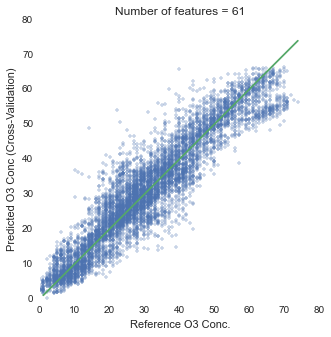

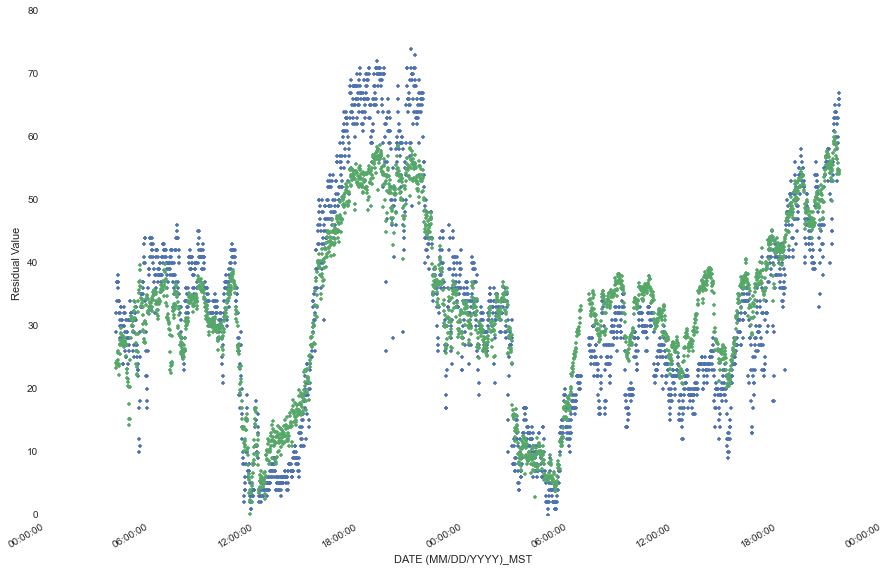

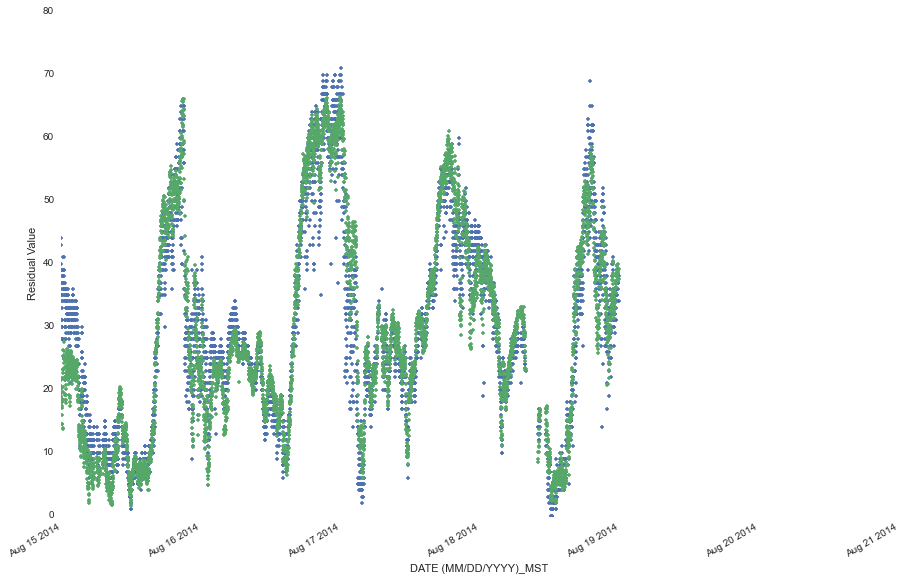

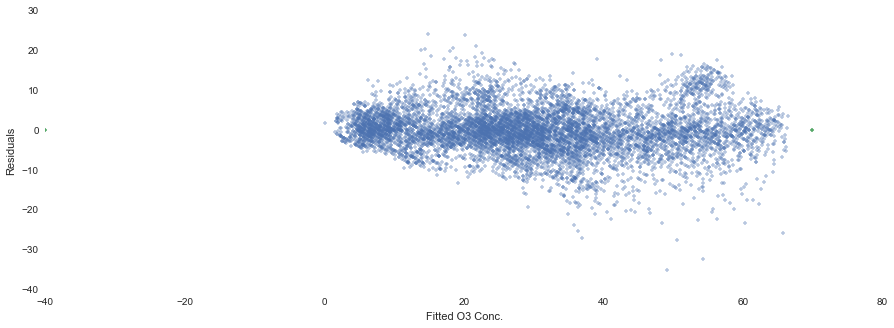

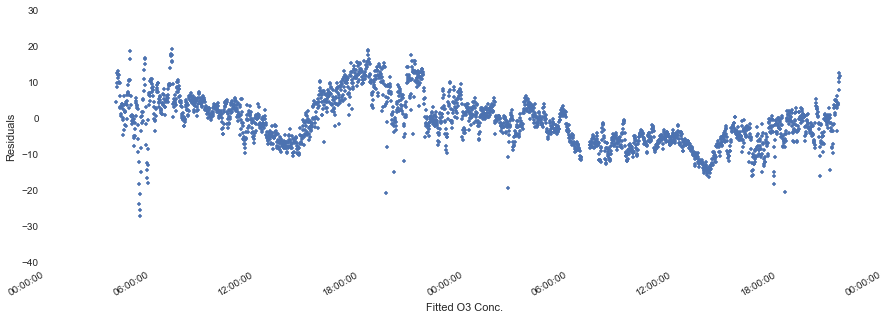

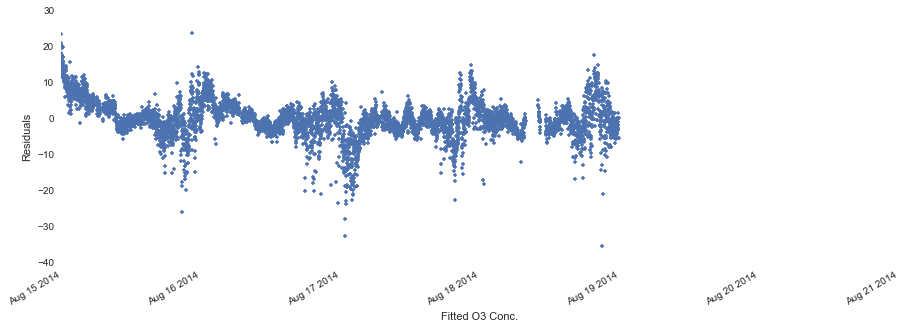

In [61]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Random Forest with all features

In [98]:
#fs_features = ['ln_O3_int_lead_5', 'Temp_int_lag_110', '03_mult_rh_sq', 'ln_rh_slope_lead_110', 'Rh_slope_lead_110', 'ln_temp_slope_lag_35', '03_mult_temp_cu', 'temp_rh_slope_lag_110', 'temp_rh_slope_lag_35', 'ln_temp_slope_lead_65', 'Temp_int_lead_20', 'Temp_slope_lag_65', 'diff', 'Temp_int_lead_5', 'o3_temp_rh_slope_lag_65', 'e2v03_int_lag_95', 'o3_temp_int_lag_95', 'ln_O3_int_lag_95', 'Temp_slope_lag_20', 'Temp_slope_lag_80', 'temp_rh_slope_lead_35', 'e2v03_slope_lead_95', 'o3_rh_int_lead_95', 'e2v03_slope_lead_80', 'ln_O3_slope_lag_20', 'ln_temp_slope_lead_80']
#num_good_feat = len(fs_features)

In [121]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 0

In [65]:
find_MSE_random_forest(df_fits, fs_features[:num_good_feat], days_tr)

NameError: name 'find_MSE_random_forest' is not defined

In [64]:
if options == 1:
    #first array is  [[day 1, day 2, ..., day n (i = 0 & j = 0)] [day 1, day 2, ..., day n (i = 0, j = 1)] [day 1, day 2, ..., day n(i = 0, j = n)]
    #second array is [[day 1, day 2, ..., day n (i = 1 & j = 0)] [day 1, day 2, ..., day n (i = 1, j = 1)] [day 1, day 2, ..., day n(i = 1, j = n)]
    #nth array is [[day 1, day 2, ..., day n (i = n & j = 0)] [day 1, day 2, ..., day n (i = n, j = 1)] [day 1, day 2, ..., day n(i = n, j = n)]
    print MSE_H
else: 
    print 'mean MSE = ', int(np.mean(MSE_H))
    print 'Daily MSE = ' + str(MSE_H)

NameError: name 'options' is not defined

In [131]:
if options == 1:
    MSE_H_per_day = MSE_H.mean(axis=2, dtype = int)
    print MSE_H_per_day

In [132]:
if options == 1:    
    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    imgplot = plt.imshow(MSE_H_per_day)
    imgplot.set_cmap('hot')
    #imgplot.set_clim(60,71)
    ax.set_aspect('equal')

    plt.colorbar(orientation='vertical')
    plt.show()
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Maximum Features at Each Split')

In [133]:
if options == 1:
    min_MSE_H = MSE_H_per_day.min()
    i,j = np.where(MSE_H_per_day == min_MSE_H)
    i = i + 1
    j = (j + 1)*5
    print 'Max features = ' + str(i)
    print 'Max depth = ' + str(j)
    print 'MSE for the holdout data = ' + str(min_MSE_H)

In [134]:
####Plot the holdout data MSE for each day.

In [135]:
def plot_daily_mse_and_features_for_day(MSE_H, day_date,feat_to_compare, title, sec_axis_label):
    from matplotlib import rc
    rc('mathtext', default='regular')

    indices = day_date
    
    #Plot the feature importances of the forest
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title(title, fontsize = 30)
    ax.bar(range(len(day_date)), MSE_H,  color="r", align="center")
    plt.xticks(range(len(day_date)), indices)
    plt.xlim([-1, len(day_date)])
    ax.set_xlabel('Date', fontsize = 18)
    ax.set_ylabel('MSE (ppb)', fontsize = 18)
    ax2 = ax.twinx()  
    ax2.set_ylabel(sec_axis_label, fontsize = 18)
    plt.plot(range(len(day_date)), feat_to_compare, marker = 'o', linestyle = '--')
    plt.show()

In [ ]:
#plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_mean,'Mean Ozone', 'ppb')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_stdev,'St. Dev. in Ozone', 'ppb')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_mean_percent,'Mean Temp.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_stdev_percent,'St. Dev.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_mean_percent,'Mean Rel. Humid.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_stdev_percent,'St. Dev. Rel. Humid.','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_mean,'Mean Pod Ozone','% of Max. during Collocation')
#plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_stdev,'St. Dev. Pod Ozone','% of Max. during Collocation')

###Plot the learning curves

In [139]:
cv = lol
ylim = (0,60)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
#declare the reference data 
y = df_all[ref_column].values

for i in range(1,30):
    X = df_all[fs_features[:i]].values 
    title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(rfr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

NameError: name 'rfr' is not defined

In [140]:
fitted_holdout_o3 = []
for d in days:
    
    #call the df_subset function to make numpy arrays out of the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features[:num_good_feat], df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d], ref_column) 
    
    #fit a linear regression on the training data
    rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
    rfr.fit(X_T, y_T)
        
    if d == days[0]:
        fitted_holdout_o3 = rfr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, rfr.predict(X_H)))

df_fit_rf = df_all.copy()
df_fit_rf['O3_fit'] = fitted_holdout_o3

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

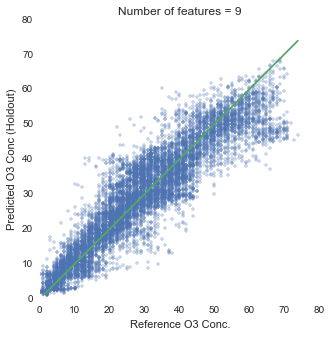

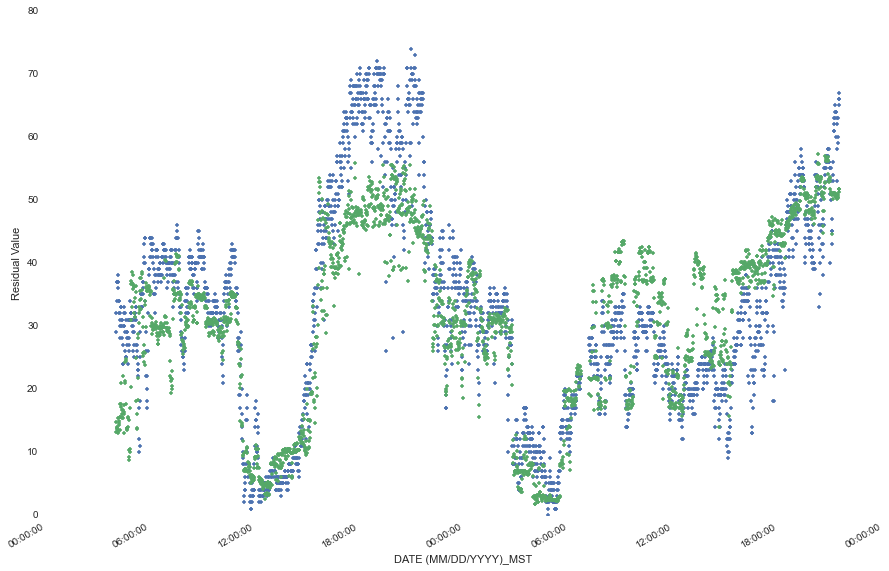

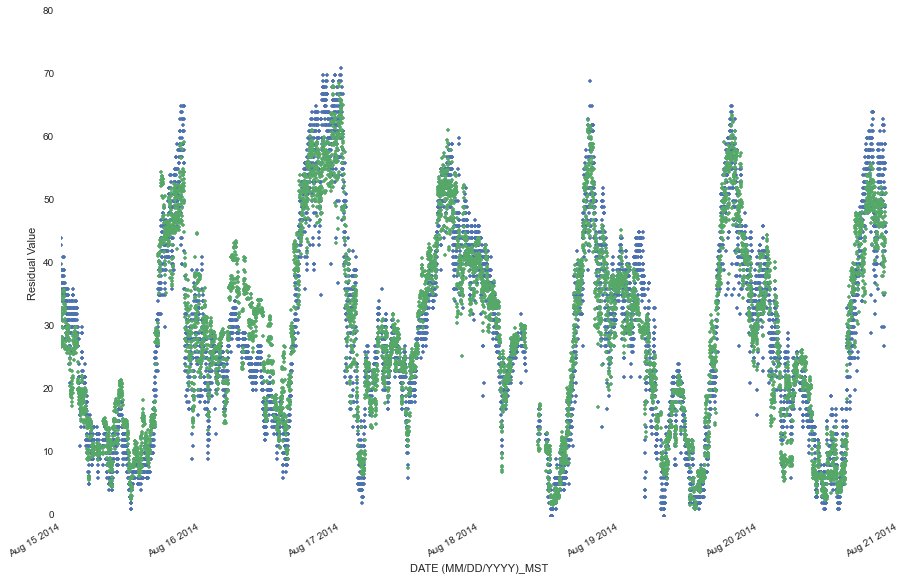

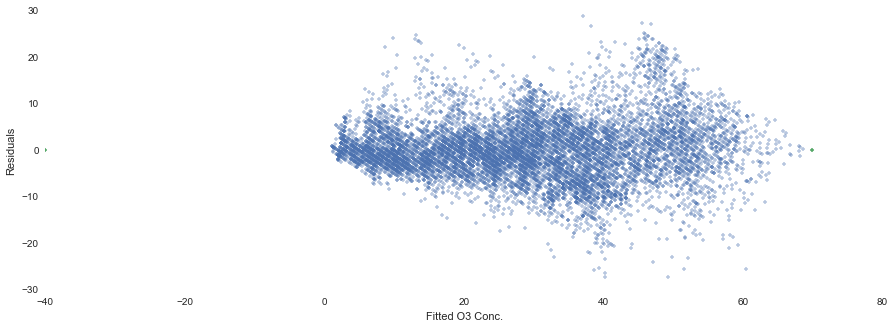

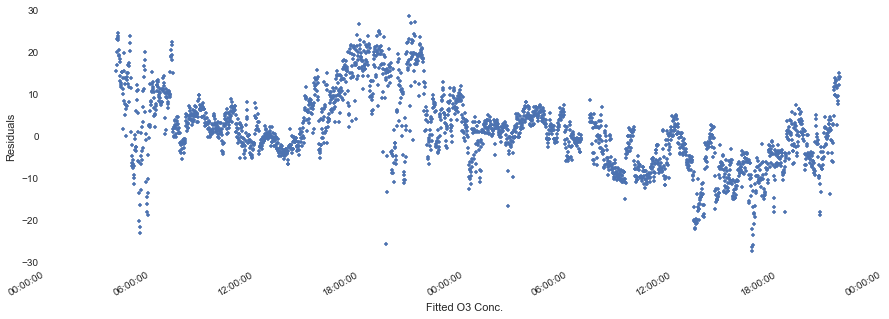

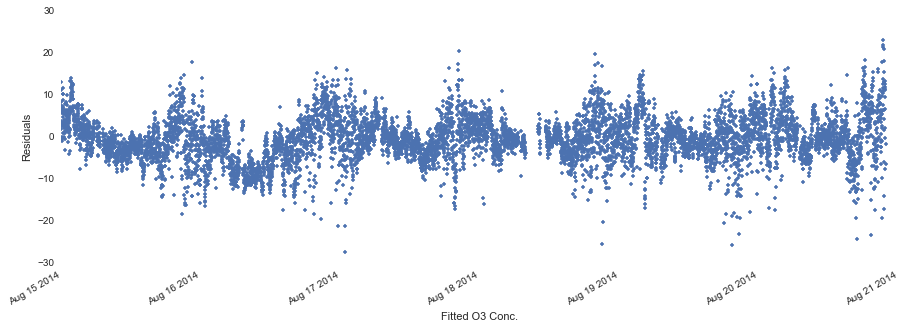

In [142]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Vector Support Machine

In [181]:
fs_features = ['ln_03_mult_ln_rh', 'UnixTime', 'ln_rh_slope_lag_110', 'temp_cu', 'ln_03_mult_ln_temp', 'o3_rh_int_lag_95', 'ln_rh_slope_lead_110', 'ln_O3_int_lag_110', 'o3_temp_int_lag_35', 'ln_o3_rh_slope_lead_110', 'ln_temp_slope_lag_95', 'Temp_slope_lag_80', 'ln_o3_rh_int_lead_35', 'ln_o3_temp_int_lead_95', 'ln_temp_rh_slope_lead_65', 'Temp_slope_lag_95', 'ln_rh_slope_lag_5', '03_sq_mult_rh_sq_&_temp_sq', 'e2v03_int_slide_2_to_12_lead', 'ln_O3_int_slide_2_to_12_lead', 'Temp_int_slide_2_to_12_lead', 'ln_temp_int_slide_2_to_12_lead', 'Rh_int_slide_2_to_12_lead', 'ln_rh_int_slide_2_to_12_lead', 'diff', 'Temp_slope_lead_20', 'ln_rh_slope_lead_5', 'ln_rh_slope_lead_20', 'ln_o3_temp_slope_lag_65', 'o3_temp_slope_lag_95', 'ln_o3_rh_slope_lag_95', 'o3_rh_slope_lag_95', 'ln_o3_temp_slope_lag_110', 'ln_o3_temp_slope_lag_35', 'Temp_slope_lead_5', 'Temp_slope_lag_20']
num_good_feat = 25

In [186]:
#define the training data
df_vsm = df_scaled[fs_features[:num_good_feat] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values

In [187]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
        
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d], ref_column)   

    # Set the parameters by cross-validation
    #vsm = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1), cv=lol, param_grid={"C": [1, 10, 100, 1000], "gamma": [1e-3, 1e-4]}, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False))
    #vsm = SVR(C=1.0, epsilon=0.2)
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [188]:
#Calculate the training and holdout MSE for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
MSE_CV = []
day_date = []
df_svm_fit = df_scaled.copy()

for d in days:
    MSE_H_day, fitted_holdout_o3 = fit_vsm_and_find_MSE(fs_features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d],d, days, fitted_holdout_o3, lol)  
    day_date.append(d)  
    MSE_CV.append(MSE_H_day)
    
df_svm_fit['o3_fit'] = fitted_holdout_o3    
print 'Cross-Validation Holdout MSE: ', np.mean(MSE_H)
print 'Daily Cross-Validation MSE: ', MSE_CV

7-11 Cross-Val MSE:  112
<bound method GridSearchCV.get_params of GridSearchCV(cv=None,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)>
7-12 Cross-Val MSE:  74
<bound method GridSearchCV.get_params of GridSearchCV(cv=None,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbo

KeyboardInterrupt: 

In [74]:
vsm.get_params

NameError: name 'vsm' is not defined

In [59]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

NameError: name 'df_fit_lasso' is not defined

In [ ]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False), cv = lol)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [ ]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom_mse':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False)))        
    elif scoring_metric == 'custom_mae':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mae_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv

#AdaBoost

In [ ]:
import sklearn.tree as tsk

#dt1 = tsk.DecisionTreeRegressor(max_depth=4) create single tree
ada = sk.AdaBoostRegressor(n_estimators = 175, learning_rate = 3)
staged_score = (X,y)

#dt1_reg = dt1.fit(X,y)   
ada_reg = ada.fit(X,y)

In [ ]:
#Get the Ada Boost classifier results
ada_cv = sk.AdaBoostClassifier(n_estimators = 175, learning_rate = 3)
#get the cross-validation scores
scores = cvs(ada_cv, X, y, cv = 10, scoring='r2')
scores.mean() 